In [8]:
import pandas as pd
import numpy as np
from pymoo.algorithms.nsga3 import NSGA3
from pymoo.algorithms.rnsga2 import RNSGA2
from pymoo.algorithms.rnsga3 import RNSGA3
from pymoo.algorithms.unsga3 import UNSGA3
from pymoo.factory import get_reference_directions
from pymoo.optimize import minimize
import pickle

from pymoo.util.termination.f_tol import MultiObjectiveSpaceToleranceTermination

from notebooks.optimization_problems.constraints import Requirements
from optimization_problems.biased_initialization import max_contact_biased
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
prefix = 'eo_' + 'telesat_'

case, target = pickle.load(open('raw/%ssettings.pkl' % prefix, 'rb'))

import util
util.print_targets(case)

Targets per orbit
T_target: 960.00 Gb (min: 624.00 Gb, max: 1296.00 Gb)
L_target: 0.00 s
E_target: 41.16 kJ (max: -0.00 kJ)
P_target: 0.00 s


In [10]:
columns = ['strand_name', 'tof',
           'r_a_x', 'r_a_y', 'r_a_z',
           'v_a_x', 'v_a_y', 'v_a_z',
           'r_b_x', 'r_b_y', 'r_b_z',
           'd',
           'r_ab_sff_x', 'r_ab_sff_y', 'r_ab_sff_z']

file_path = "raw/%spost_processed.h5" % prefix

row_limit = -1

store = pd.HDFStore(file_path)

instances_df = store.select('contact_instances', 'columns = %s' % str(columns), stop = row_limit)

# Sort by pass id
instances_df = instances_df.sort_index(0)

In [11]:
from notebooks.optimization_problems.design_vector import design_vector_default_scm, SystemParameters

sys_param = SystemParameters()
sys_param.fc_Hz = target['frequency']
sys_param.GT_dBK = target['GT_dBK']
sys_param.margin_dB = 3.0
sys_param.B_Hz_array = np.array([0.1, 0.5, 1, 10, 50, 100, 200, 300]) * 1e6
sys_param.Gtx_dBi_bounds = (3., 43.)
sys_param.Ptx_dBm_bounds = (20., 43.)

modcods_df = pd.read_pickle('../dvbs2.pkl')

sys_param.EsN0_req_dB_array = modcods_df[['isend', 'isend_200MHz', 'isend_300MHz']].to_numpy()
sys_param.eta_bitsym_array = modcods_df[['eta', 'eta_200MHz', 'eta_300MHz']].to_numpy()
sys_param.eta_maee_array = modcods_df[['maee_12', 'maee_12_200MHz', 'maee_12_300MHz']].to_numpy()

requirements = case['requirements']
requirements.max_throughput = -1

### Problem definition
Defines a ExtendandCombinedProblem

In [12]:
from combined_problem import ExtendedCombinedProblem
problem = ExtendedCombinedProblem(instances_df, sys_param, requirements=requirements, f_mask=np.array([1, 2, 3]))
sampling, crossover, mutation = design_vector_default_scm(problem.x_length, problem.x_indices)

Algorithm settings

Generating biased initial population
Running initial conditions optimization...
init_ref_dirs: 101
init_pop_size: 200
init_n_offsprings: 50
Running initial conditions optimization...
Plotting 9 results
Generating initial population of size 300...
Selected setting: NSGA 3 ref_dirs=171, pop_size=200, n_offsprings=50


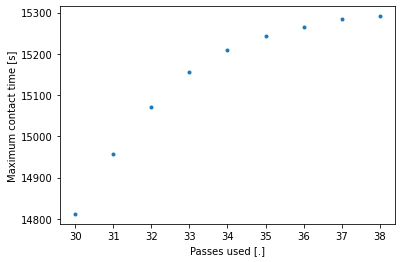

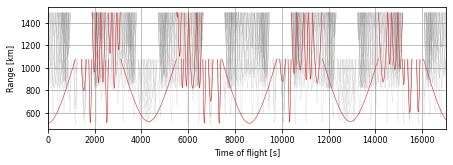

In [16]:
settings = {}

# NSGA-III
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=23)
pop_size=int(np.ceil(len(ref_dirs) / 100) * 100)
n_offsprings=int(np.ceil(len(ref_dirs) / 100) * 100 / 4)

from os import path
file_name = 'raw/%sbiased_inits.pkl' % (prefix)

if path.exists(file_name):
    print("Loading biased initial population")
    biased_init = pickle.load(open(file_name, 'rb'))
else:
    print("Generating biased initial population")
    biased_init = max_contact_biased(instances_df, sys_param, case, pop_size)
    pickle.dump(biased_init, open(file_name, 'wb'))

settings['NSGA-III-BIASED'] = {
    'label': 'nsga3',
    'algorithm': NSGA3(
        pop_size=pop_size,
        n_offsprings=n_offsprings,
        sampling=biased_init,
        crossover=crossover,
        mutation=mutation,
        ref_dirs=ref_dirs,
        eliminate_duplicates=True,
    ),
    'desc': 'NSGA 3 biased (ref_dirs=%d, pop_size=%d, n_offsprings=%d)' % (len(ref_dirs), pop_size, n_offsprings),
    'file_label': 'nsga3_%d_%d_%d' % (len(ref_dirs), pop_size, n_offsprings),
    'termination': ""
}

# NSGA-III unbiased
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=17)
pop_size=int(np.ceil(len(ref_dirs) / 100) * 100)
n_offsprings=int(np.ceil(len(ref_dirs) / 100) * 100 / 4)

settings['NSGA-III'] = {
    'label': 'nsga3',
    'algorithm': NSGA3(
        pop_size=pop_size,
        n_offsprings=n_offsprings,
        sampling=sampling,
        crossover=crossover,
        mutation=mutation,
        ref_dirs=ref_dirs,
        eliminate_duplicates=True,
    ),
    'desc': 'NSGA 3 (ref_dirs=%d, pop_size=%d, n_offsprings=%d)' % (len(ref_dirs), pop_size, n_offsprings),
    'file_label': 'nsga3_unbiased_%d_%d_%d' % (len(ref_dirs), pop_size, n_offsprings),
    'termination': ""
}

setting = settings['NSGA-III-BIASED']
setting = settings['NSGA-III']

print("Selected setting: %s" % setting['desc'])

Setting up optimization files

In [17]:
termination = setting['termination']
algorithm = setting['algorithm']

n_gen_inc = 100

from os import path

file_name = 'raw/%s%s.pkl' % (prefix, setting['file_label'])

if path.exists(file_name):
    print("Loading: %s" % file_name)
    problem, setting, res = pickle.load(open(file_name, 'rb'))
    algorithm = res.algorithm
    algorithm.has_terminated = False
    n_gen = res.algorithm.n_gen
else:
    print("New optimization starting...")
    n_gen = 0

New optimization starting...


In [ ]:
n_gen = n_gen + n_gen_inc
print("Maximum number of generations: %d" % n_gen)
termination = ('n_gen', n_gen)

In [ ]:
print("Starting optimization...")

res = minimize(problem,
               algorithm,
               termination,
               #termination=termination,
               seed=1,
               #save_history=True,
               verbose=True,
               copy_algorithm=False,
               )

print('Processes:', res.exec_time)
print("Best solution found: %s" % res.X)

pickle.dump((problem, setting, res), open(file_name, 'wb'))

In [ ]:
from beepy import beep
for i in range(3):
    beep(sound=5)
